# Parte 1 
# 1 Analisar as distribuições das variáveis para ver se estão enviesadas e precisam de correção; tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso.

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' # set 'png' here when working on notebook
%matplotlib inline

Carregando os dados

In [10]:
train = pd.read_csv("data/eleicoes_2006_TREINO_CONFIGURADO_LIBRE.csv", index_col="nome")
del train['sequencial_candidato']
del train['cargo']
del train['ano']
test = pd.read_csv("data/eleicoes_2010_TESTE_CONFIGURADO_LIBRE.csv", index_col="nome")

del test['sequencial_candidato']
del test['cargo']
del test['ano']
all_data = pd.concat((train.loc[:,'quantidade_doacoes':'votos'], test.loc[:,'quantidade_doacoes':'votos']))

# 2 Analisar as distribuições das variáveis para ver se estão enviesadas e precisam de correção; tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso.

Normalização: First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log(price + 1)'}>]], dtype=object)

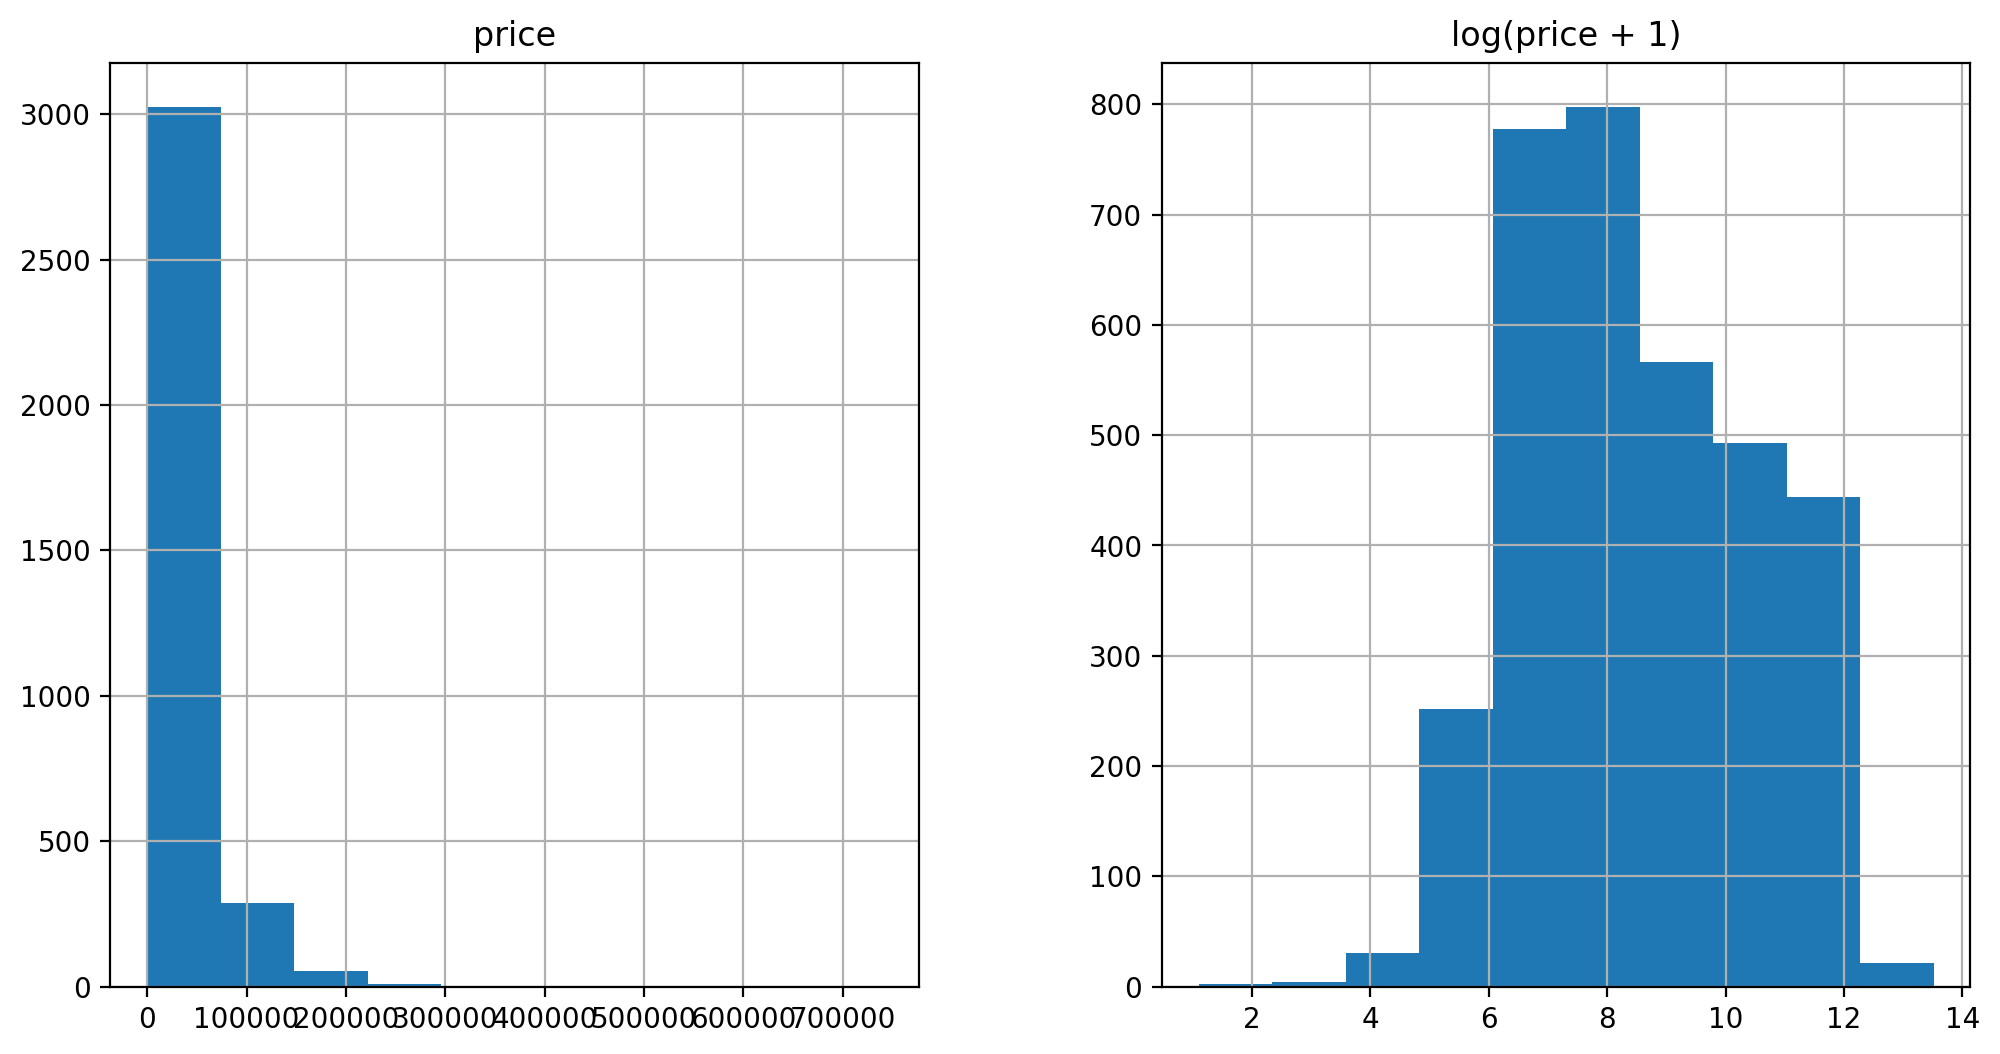

In [11]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame(
    {
        "price" : train["votos"], 
         "log(price + 1)" : np.log1p(train["votos"])
    }
)
prices.hist()

In [12]:
# log transform the target
train["votos"] = np.log1p(train["votos"])

In [13]:
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) # compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

Tratamento de valores ausentes: Create Dummy variables for the categorical features Replace the numeric missing values (NaN's) with the mean of their respective columns

In [14]:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

Construir modelos de regressão com (ridge e lasso) e sem regularização.

Models Now we are going to use regularized linear regression models from scikit learn module. I'm going to try both l_1 (lasso) and l_2 (Ridge) regularization. I'll also define a function that returns the cross-validation rmse error we can evaluate our models and pick the best tuning par.

In [15]:
# creating matrices for sklearn
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.votos

In [17]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring = "neg_mean_squared_error", cv = 5 ))
    return (rmse)

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexibe our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [18]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv (Ridge (alpha = alpha)).mean() for alpha in alphas]

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexibe our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

Text(0, 0.5, 'rmse')

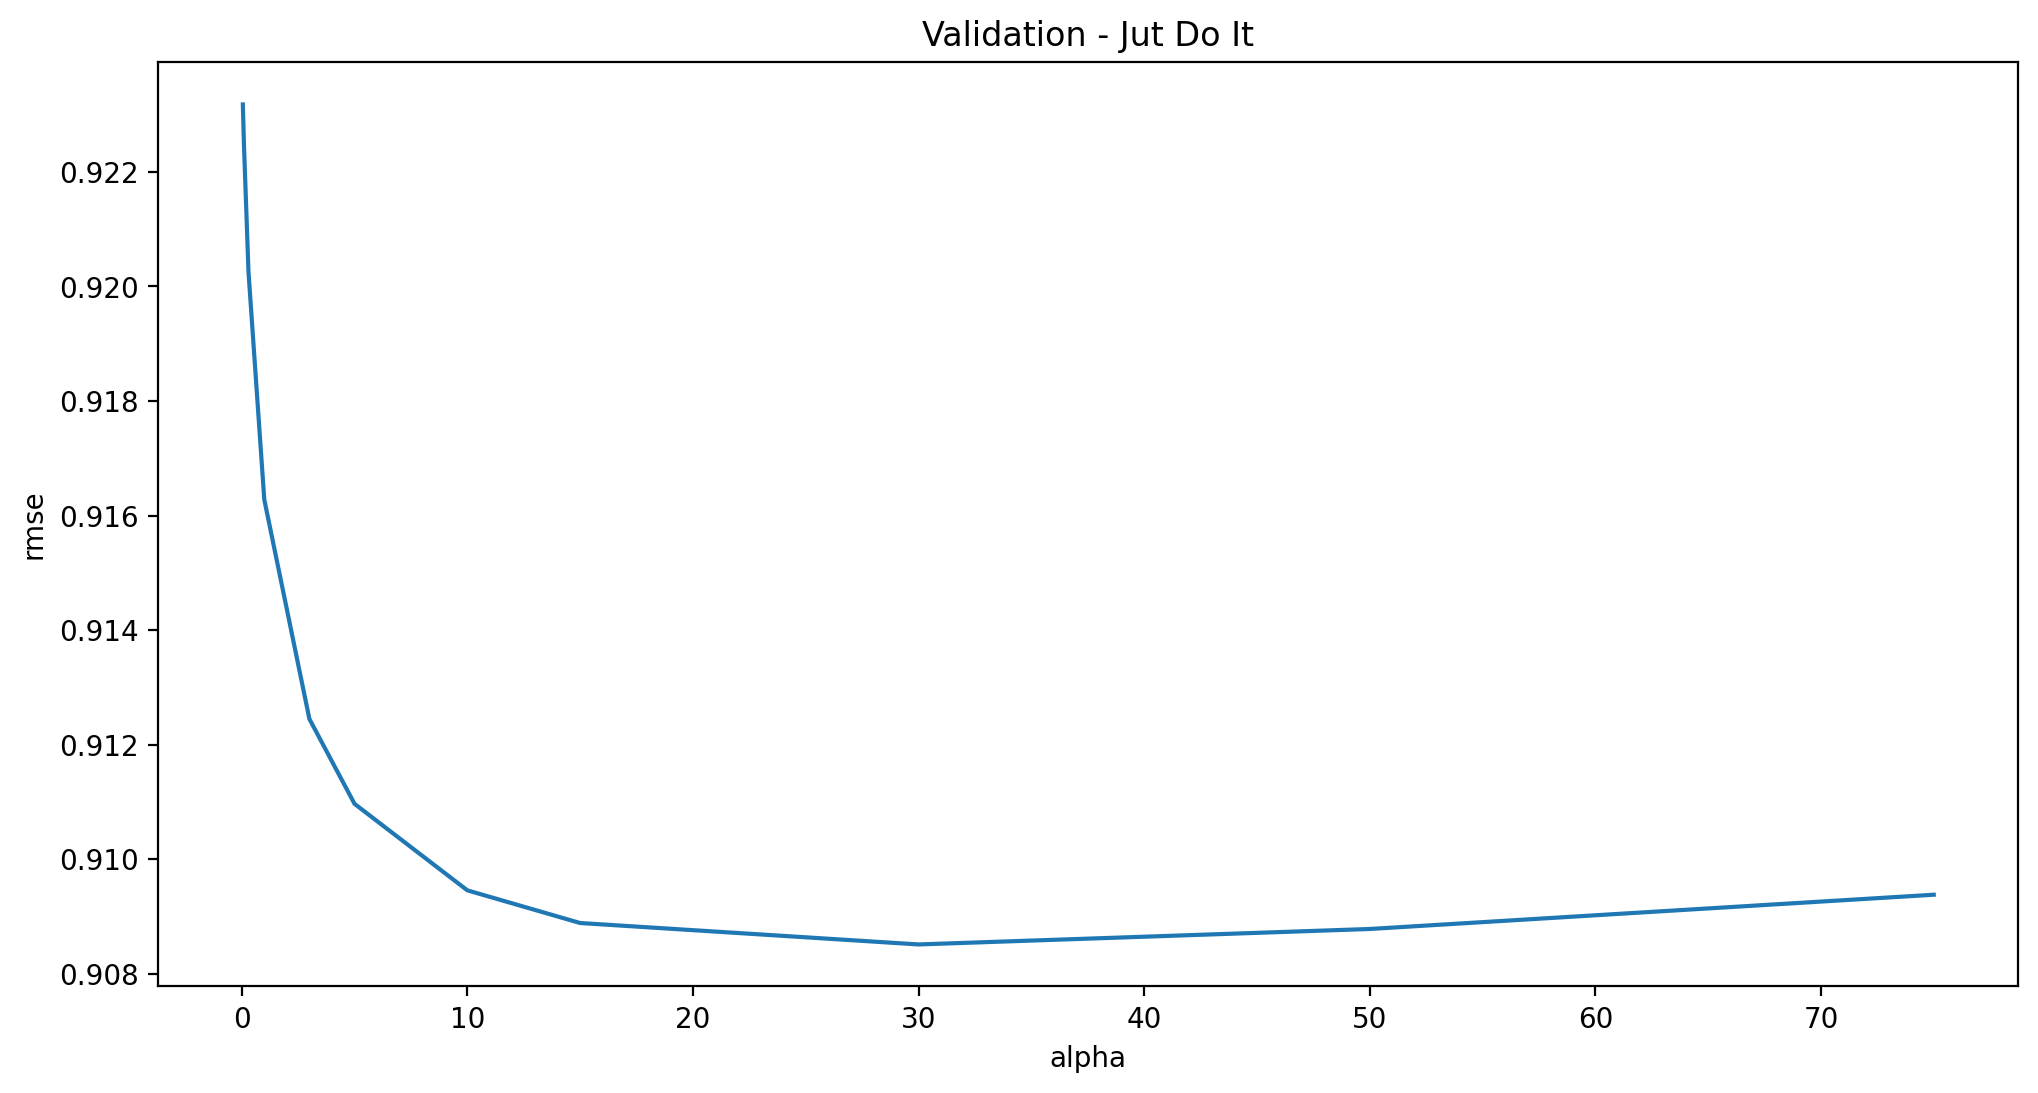

In [19]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Jut Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexibe (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot abova.

In [20]:
cv_ridge.min()

0.908512641693385

So for the Ridge regression we get a rmsle of about 0.87 Let's try out the Lasso model. We will do a slightly different approach here and use the buil in Lasso CV to figure out the best alpha for us. For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge

In [21]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], max_iter=60000000).fit(X_train, y)

In [22]:
rmse_cv(model_lasso).mean()

0.9101543257964085

Nice! The lasso performs even better so we'll just use this one predict on the test set. Another neat thing about the Lasso is that is tt dows feature selection for you - setting coeficientes of feature it deems unimportant to zero. Let's take a look at the coefficients.

In [23]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [24]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + str(sum(coef ==0)) + " variables") 

Lasso picked 57 variables and eliminated the other 145 variables


Googd job Lasso. One thing to note here however is that the features selected ae not necessarily the "correct" ones - especialy since there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on bootstrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most importatn coeffcicients are:

In [25]:
imp_coef = pd.concat([coef.sort_values().head(10),
                      coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

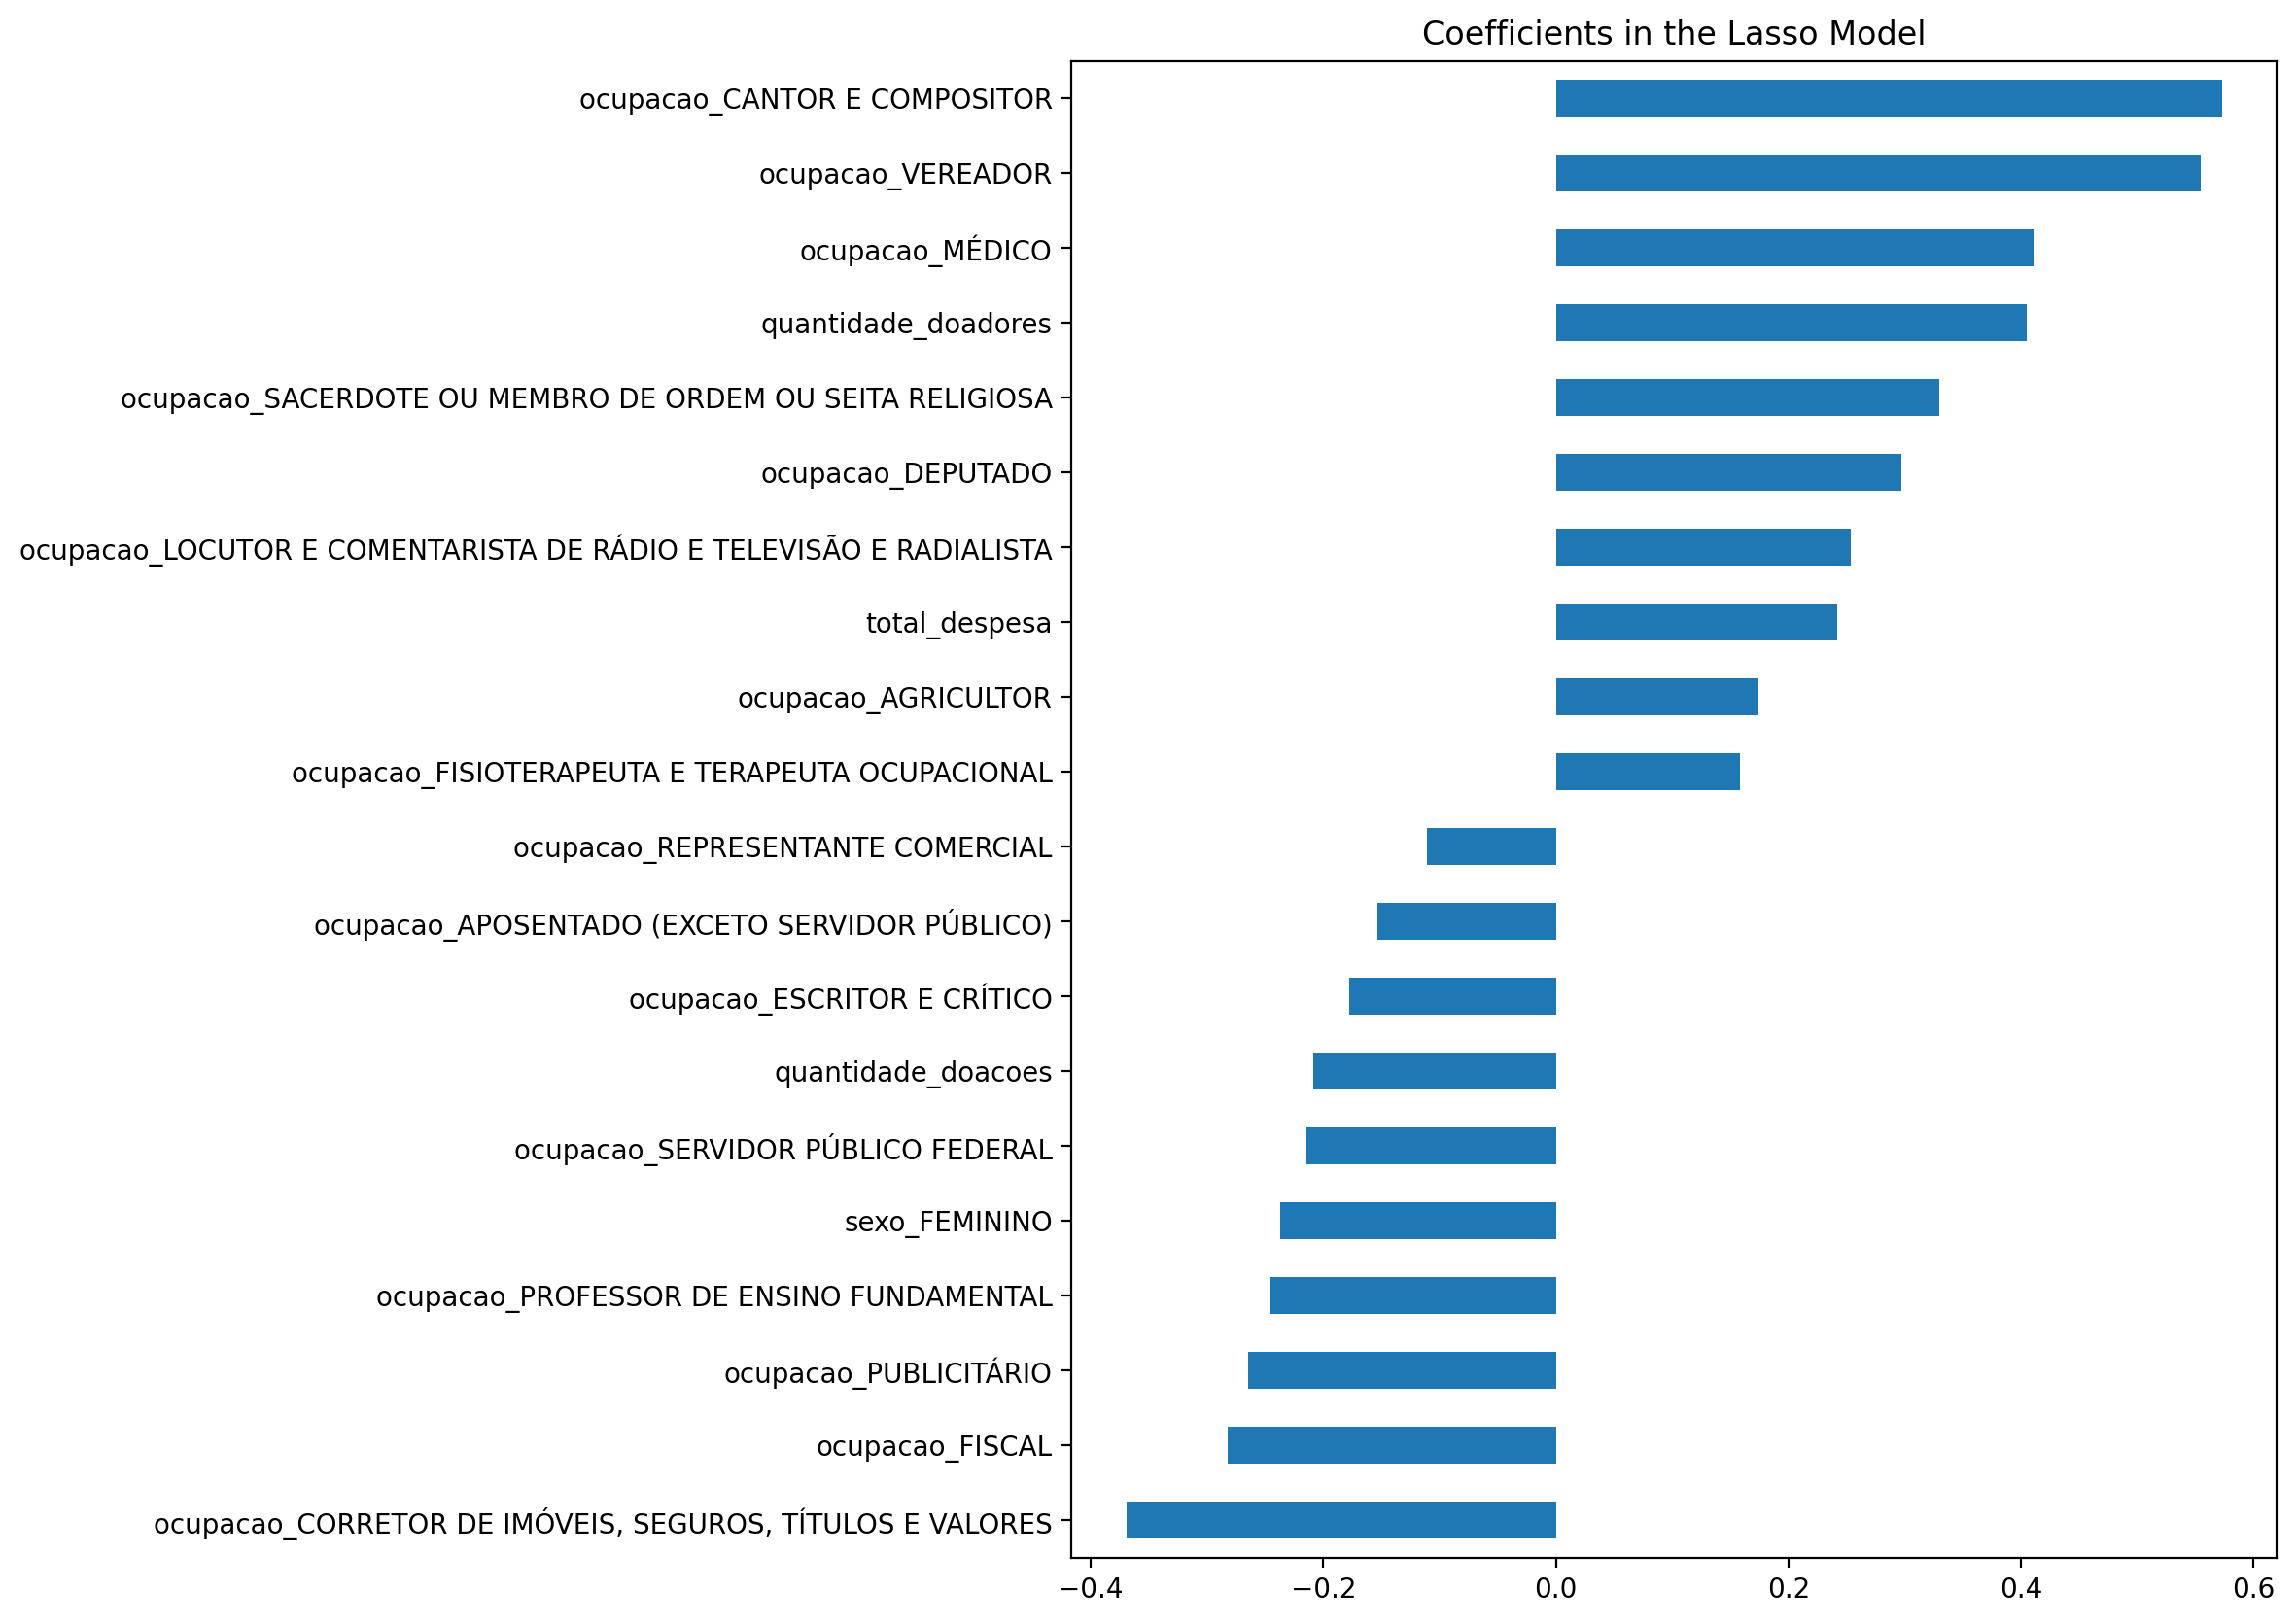

In [26]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

<AxesSubplot:xlabel='preds', ylabel='residuals'>

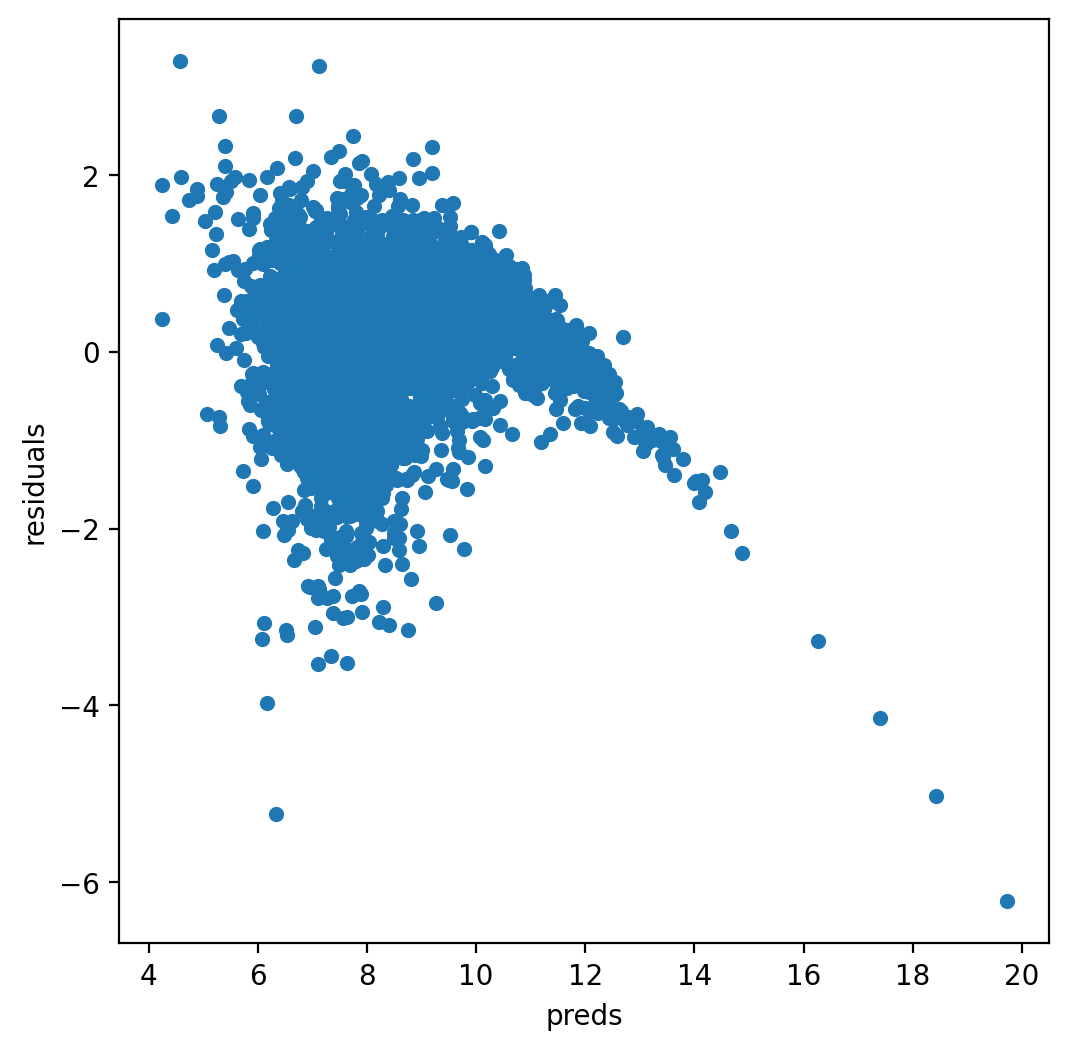

In [27]:
# lets look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true": y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

In [28]:
#!pip install xgboost
import xgboost as xgb

In [29]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)

<AxesSubplot:>

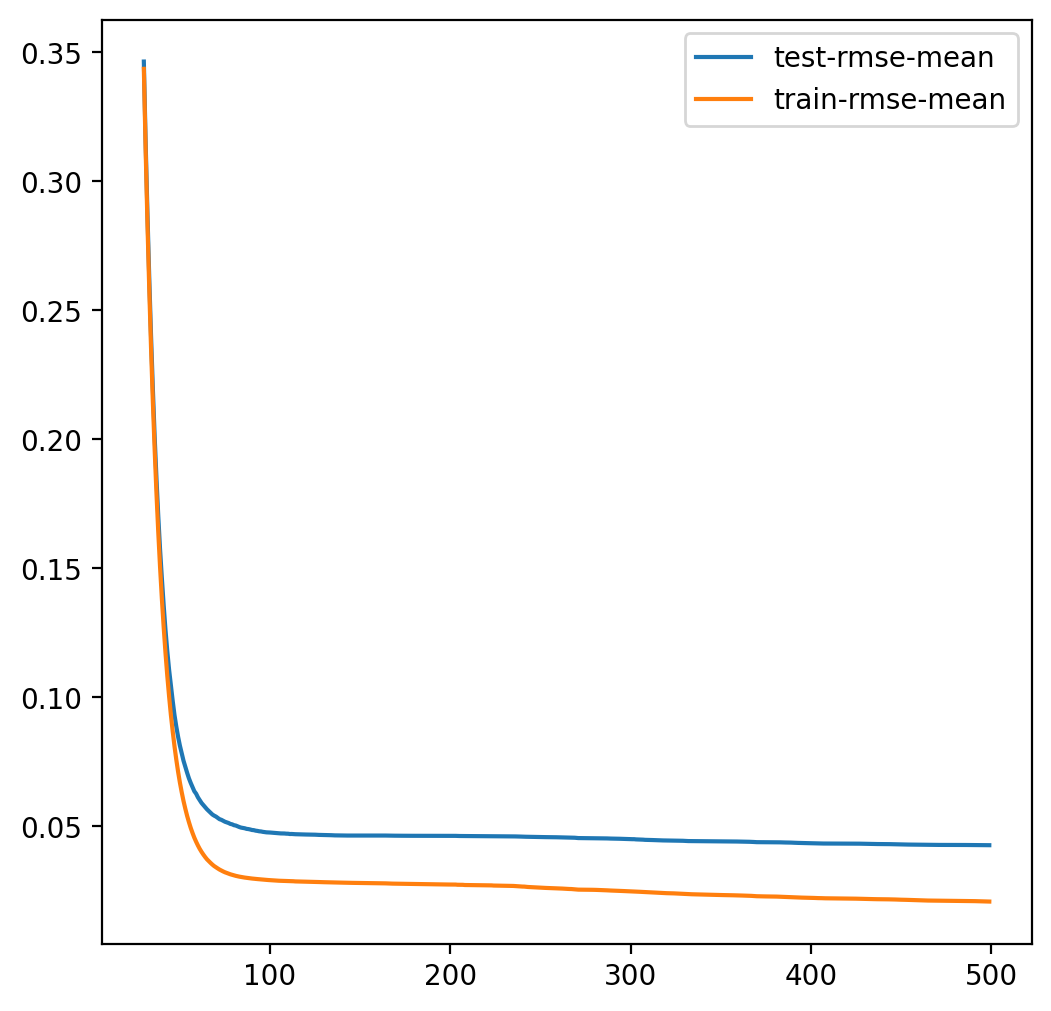

In [30]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [31]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=360, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [32]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

<AxesSubplot:xlabel='xgb', ylabel='lasso'>

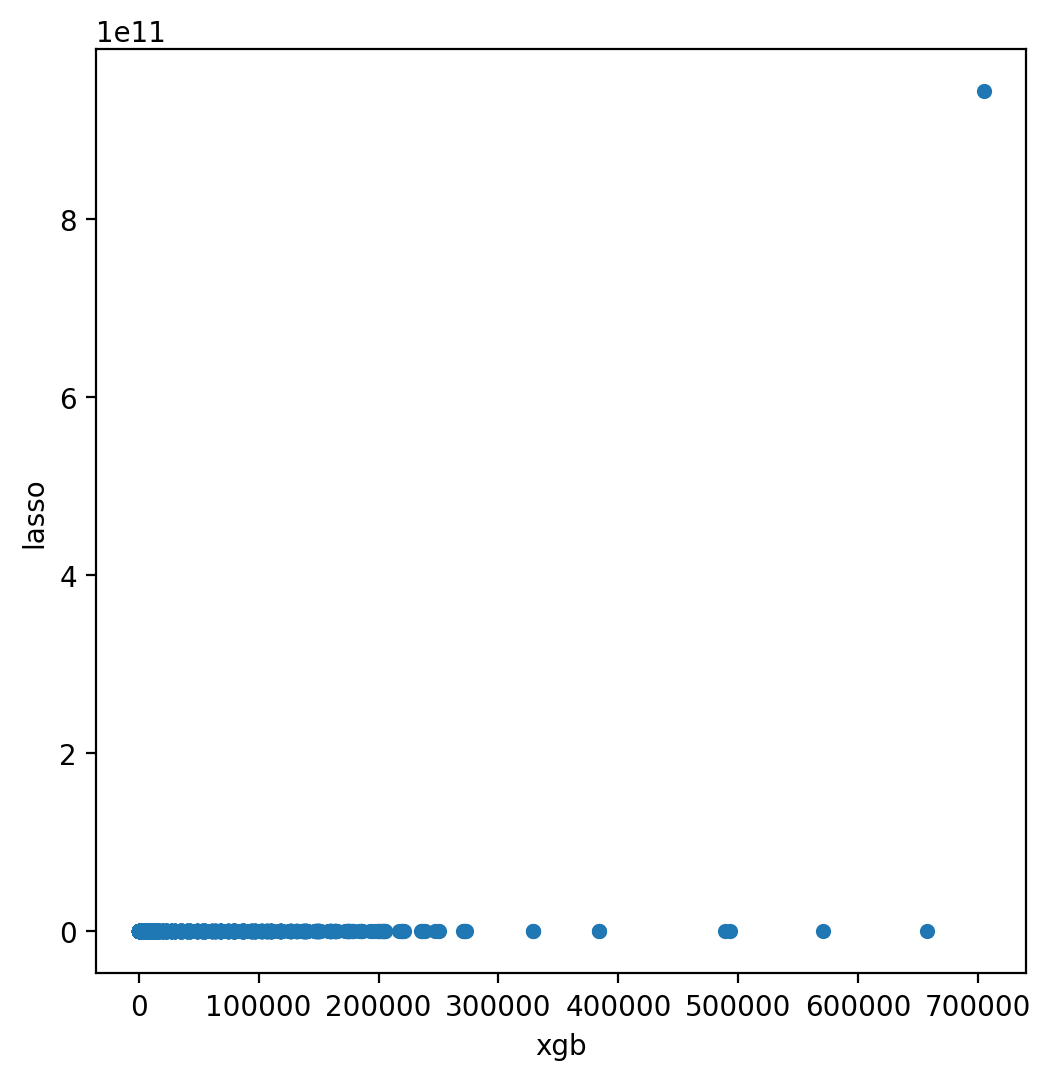

In [33]:
predictions = pd.DataFrame({"xgb": xgb_preds, "lasso":lasso_preds})
predictions.plot(x= "xgb", y = "lasso", kind = "scatter")

<AxesSubplot:>

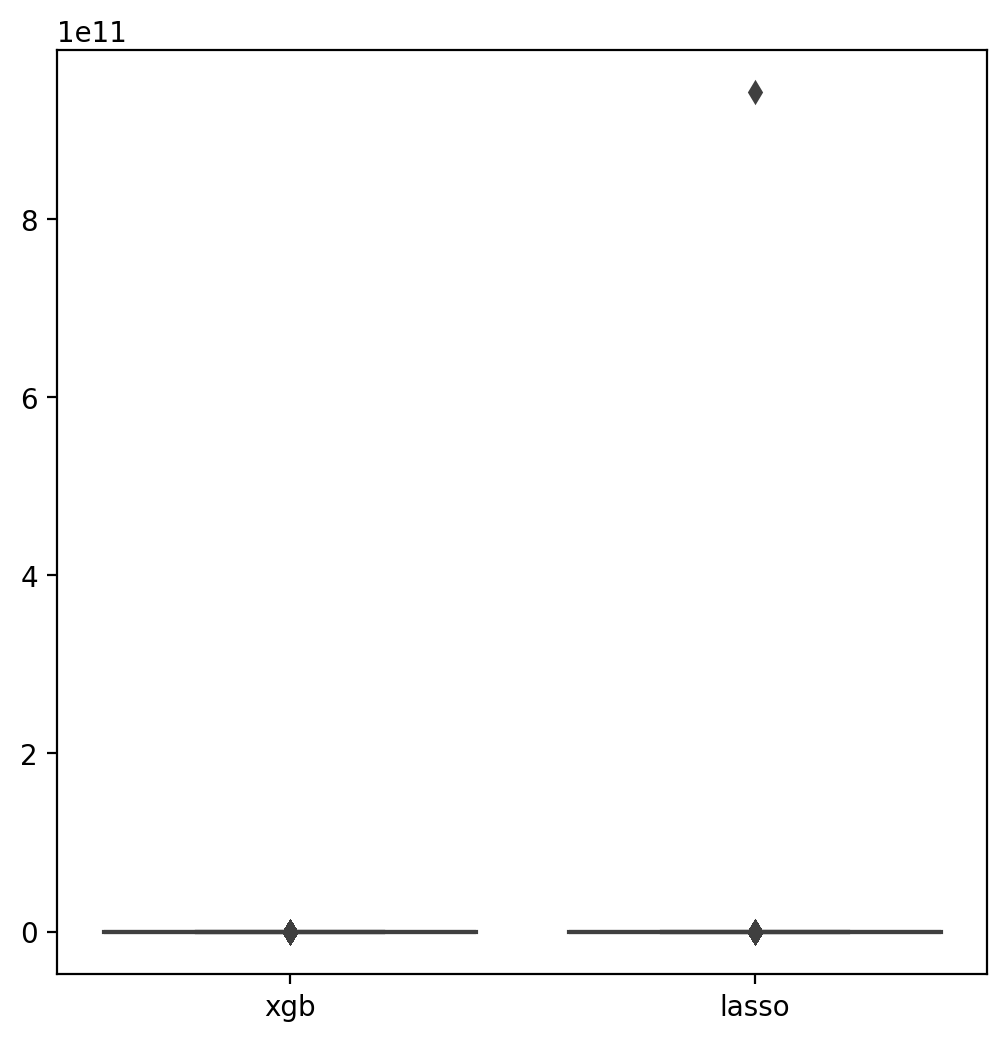

In [34]:
import seaborn as sns
sns.boxplot(predictions)

<AxesSubplot:xlabel='xgb', ylabel='lasso'>

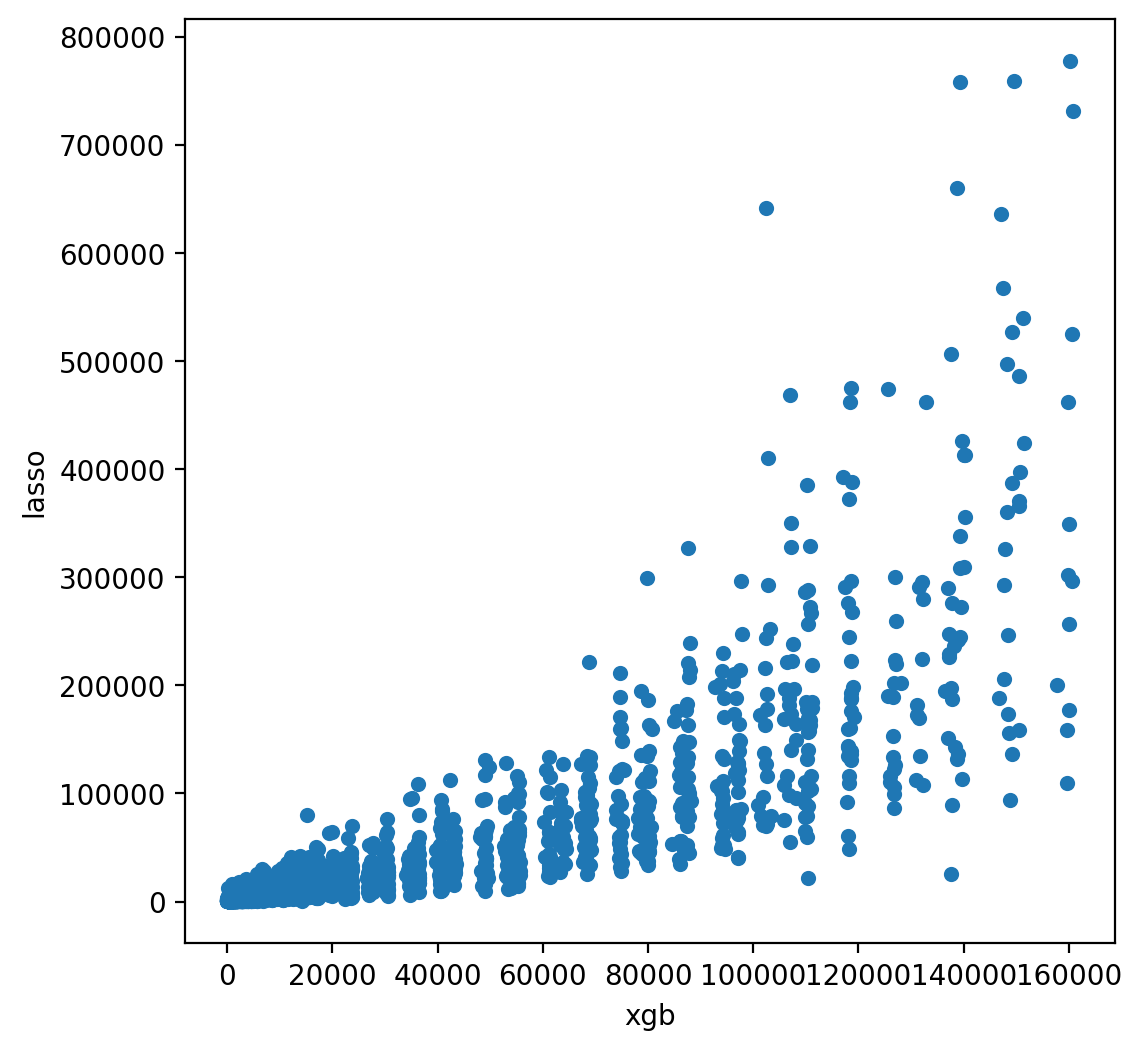

In [35]:
predictions = pd.DataFrame({"xgb": xgb_preds, "lasso":lasso_preds})
import numpy as np
from scipy import stats
predictions = predictions[(np.abs(stats.zscore(predictions)) < 3).all(axis=1)]
predictions.plot(x= "xgb", y = "lasso", kind = "scatter")

<AxesSubplot:>

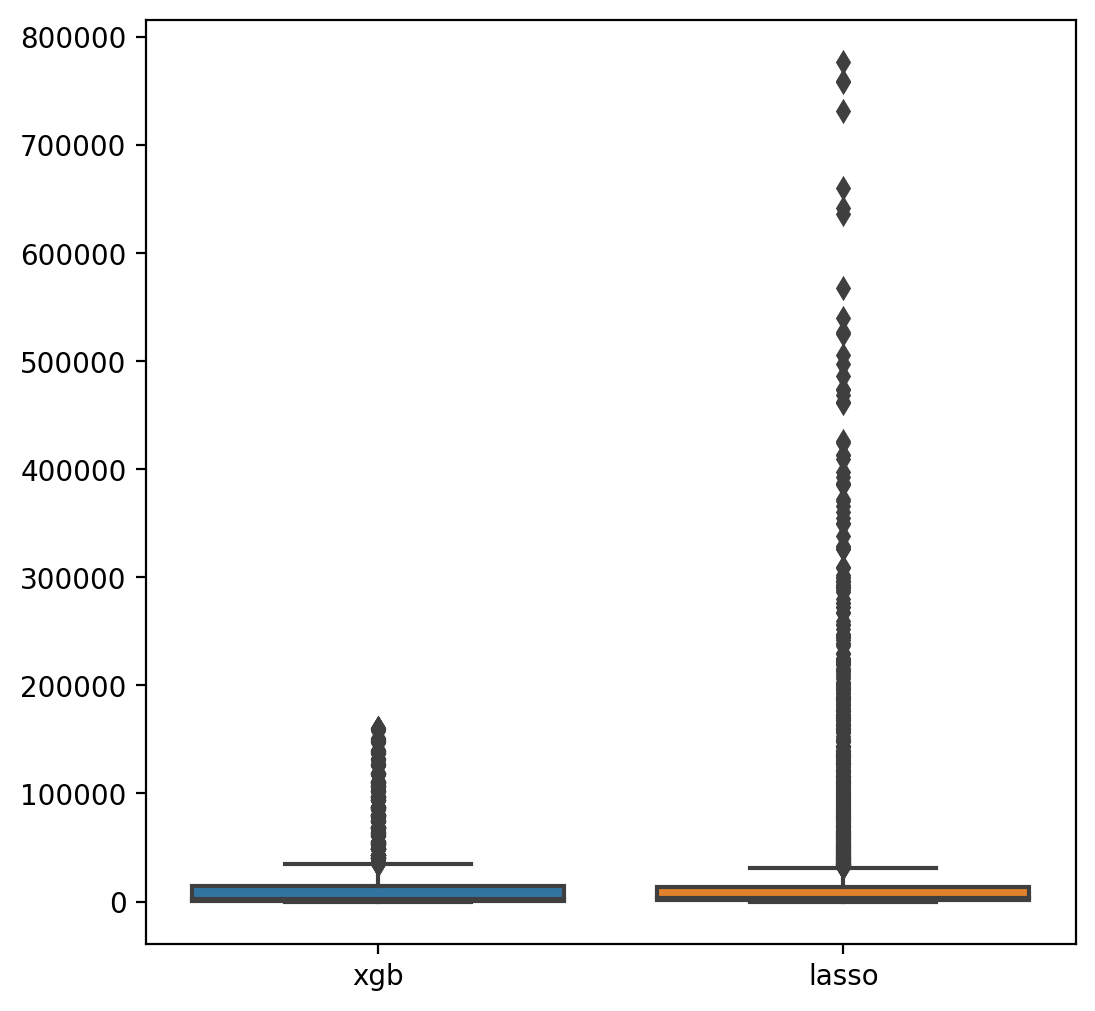

In [36]:
import seaborn as sns
sns.boxplot(predictions)

In [37]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [38]:
solution = pd.DataFrame({"nome":test.index, "votos":preds})
solution.to_csv("ridge_sol.csv", index = False)

In [39]:
solution

,nome,votos
0,ANTONIA LUCILEIA CRUZ RAMOS CAMARA,17348.075404
1,DEODATO NUNES DE FRANÇA,2984.454404
2,EDSON FIRMINO DE PAULA,949.135310
3,ELISABETH APARECIDA GARCIA RODRIGUES,795.163787
4,FLAVIANO FLAVIO BAPTISTA DE MELO,26237.410062
...,...,...
3937,ROBERTO PEREIRA URBANO,2197.163927
3938,RONALDO DIMAS NOGUEIRA PEREIRA,87115.424887
3939,SÉRGIO PERIN,995.860258
3940,ÍTALO MARCEL COSTA CONCEIÇÃO,1285.699536


# Parte 2

# 3. Considerar outros modelos ainda não vistos em sala de sua escolha (e.g. SVR, Regression Trees, KNN e Random Florests).
## Tentativa com SVR

In [45]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Dados de Treino
train = pd.read_csv("data/eleicoes_2006_TREINO_CONFIGURADO_LIBRE.csv", index_col="nome")
del train['sequencial_candidato']
del train['cargo']
del train['ano']
train = pd.get_dummies(train)
train = train.fillna(train.mean())
X = train.loc[:,'quantidade_doacoes':'media_despesa']
y = train.loc[:,'votos']
# Dados de Teste
test = pd.read_csv("data/eleicoes_2010_TESTE_CONFIGURADO_LIBRE.csv", index_col="nome")
del test['sequencial_candidato']
del test['cargo']
del test['ano']
test = pd.get_dummies(test)
test = test.fillna(test.mean())
X_test = test.loc[:,'quantidade_doacoes':'media_despesa']
y_test = test.loc[:,'votos']

In [46]:
model_svr = svm.SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
model_svr.fit(X, y)

SVR()

In [47]:
y_pred = model_svr.predict(X_test)

In [48]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

53420.64742701079

### SVR Tunar os hiperâmetros para cada caso e retornar os rmses
Mudar os parametros do svm
O parâmetro C é um trade off (escolha) entre a incorreta classificação de exemplos de treinamento contra a simplicidade da superfície de decisão. Um C baixo torna a superfície de decisão suave, enquanto um C alto visa classificar todos os exemplos de treinamento corretamente, dando ao modelo liberdade para selecionar mais amostras como vetores de suporte. O parâmetro gamma define qual é a influência de um único exemplo de treinamento. É um coeficiente de kernel para 'rbf', 'poli' e 'sigmóide'. Se gamma for definido como 'auto' então 1/n_features serão usados. Valores baixos significam 'alta variância' e maior influência do vetor de suporte e valores altos significam 'baixa variância' e os vetores de suporte não possuem grande influência no processo de classificação. Os parâmetros gama podem ser vistos como o inverso do raio de influência de amostras selecionadas pelo modelo como vetores de suporte.

In [49]:
def testar_kernels(kernels):
    for kernel in kernels:
        classifier = svm.SVR(kernel=kernel, degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1 )
        classifier.fit(X, y)
        prediction_SVM = classifier.predict(X_test)
        print("kernel: ",kernel)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        print("rmse: ", rmse)
        print("\n")

#kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
kernels = ['poly', 'rbf', 'sigmoid']
#['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
# o tempo de processamento do kernel linear é alto em relação aos demais
testar_kernels(kernels)

kernel:  poly
rmse:  53420.64742701079


kernel:  rbf
rmse:  53420.64742701079


kernel:  sigmoid
rmse:  53420.64742701079




## SVR Tentativa Validação Cruzada  

In [50]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, train, y, scoring = "neg_mean_squared_error", cv = 5 ))
    return (rmse)

In [51]:
rmse_cv(model_svr).mean()

48813.72929931288

### A validação cruzada baixou o rmse

## Tentativa com KNN

In [52]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Dados de Treino
train_knn = pd.read_csv("data/eleicoes_2006_TREINO_CONFIGURADO_LIBRE.csv", index_col="nome")
del train_knn['sequencial_candidato']
del train_knn['cargo']
del train_knn['ano']
train_knn = pd.get_dummies(train_knn)
train_knn = train_knn.fillna(train_knn.mean())
X_knn = train_knn.loc[:,'quantidade_doacoes':'media_despesa']
y_knn = train_knn.loc[:,'votos']
# Dados de Teste
test_knn = pd.read_csv("data/eleicoes_2010_TESTE_CONFIGURADO_LIBRE.csv", index_col="nome")
del test_knn['sequencial_candidato']
del test_knn['cargo']
del test_knn['ano']
test_knn = pd.get_dummies(test_knn)
test_knn = test_knn.fillna(test_knn.mean())
X_test_knn = test_knn.loc[:,'quantidade_doacoes':'media_despesa']
y_test_knn = test_knn.loc[:,'votos']

In [53]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier()
model_knn.fit(X_knn, y_knn)

y_pred_knn = model_knn.predict(X_test_knn)

In [54]:
print("Accuracy on test set (Knn): {:.3f}".format(model_knn.score(X_test_knn, y_test_knn)))

Accuracy on test set (Knn): 0.000


In [55]:
rmse = mean_squared_error(y_test_knn, y_pred_knn, squared=False)
rmse

41707.488670326806

## Tentativa Validação Cruzada KNN

In [56]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, train_knn, y_knn, scoring = "neg_mean_squared_error", cv = 5 ))
    return (rmse)

In [57]:
rmse_cv(model_knn).mean()

c:\users\gisel\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


31638.06584945863

### A validação cruzada baixou o rmse

# 5. Plotar os resíduos versus predições e analisar se esses plots representam bons indícios da adequabilidade dos modelos a esse problema.

## Modelo SVR 

<AxesSubplot:xlabel='preds', ylabel='residuals'>

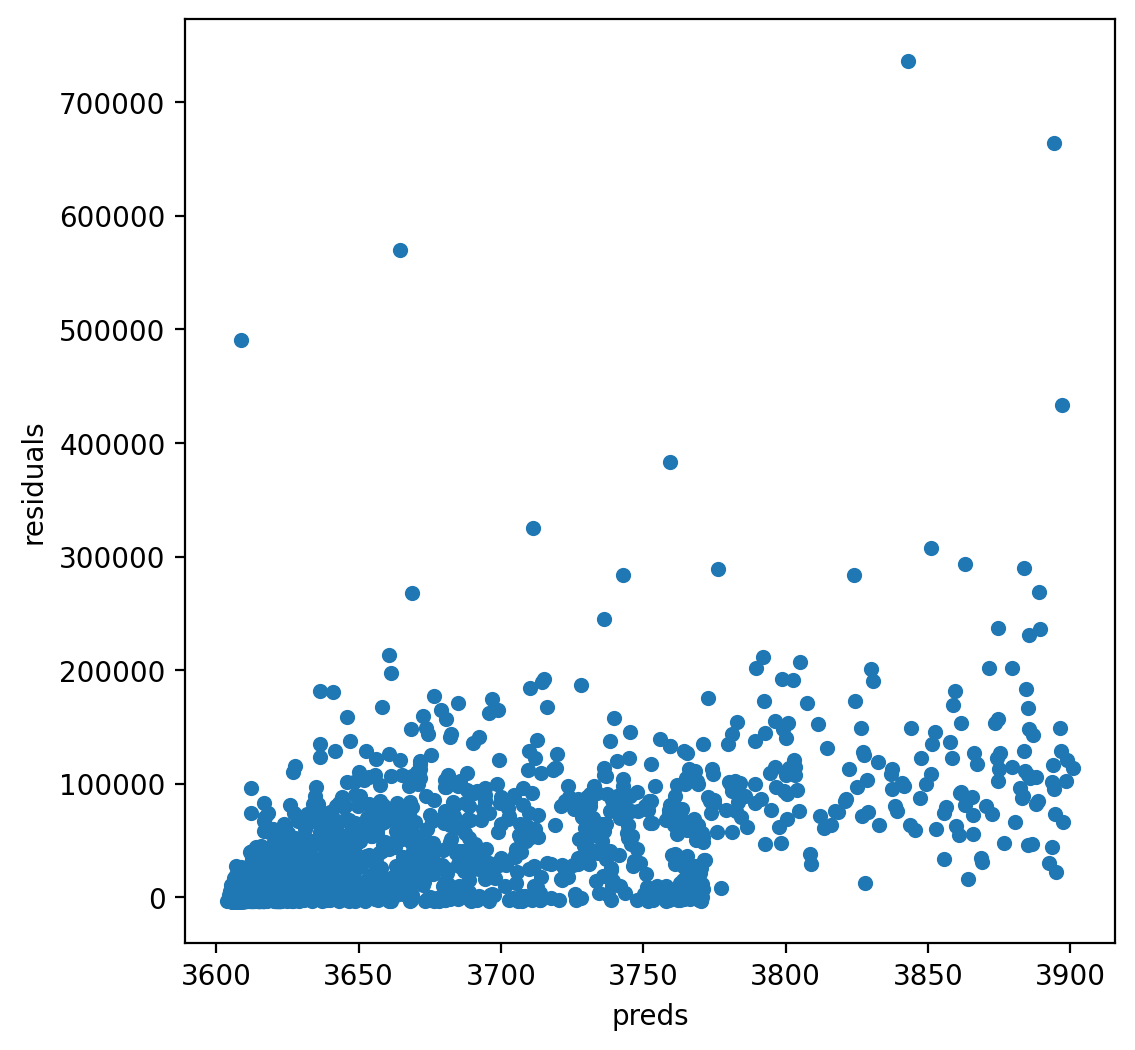

In [62]:
# lets look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_svr.predict(X), "true": y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

In [63]:
## Modelo KNN

<AxesSubplot:xlabel='preds', ylabel='residuals'>

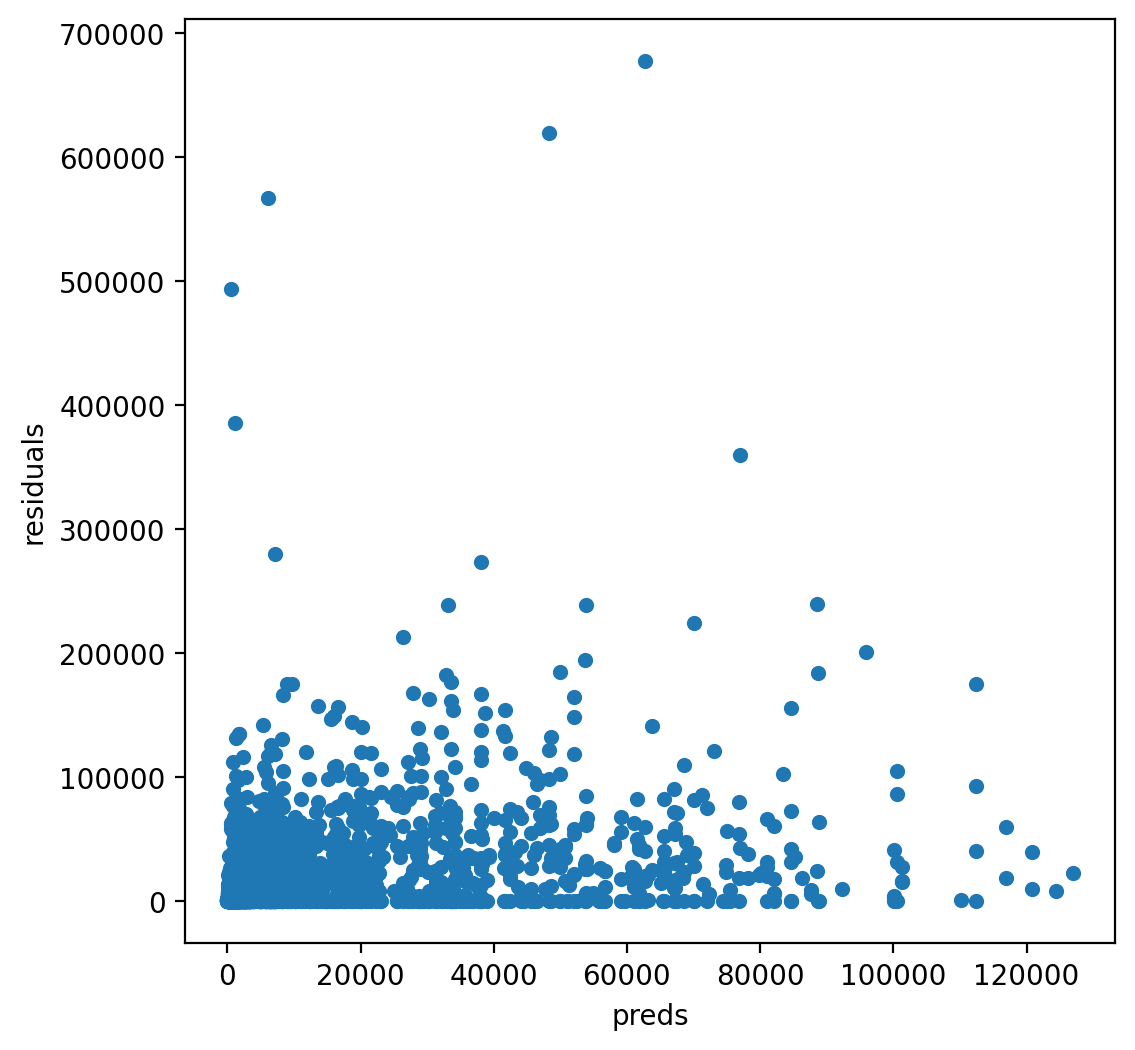

In [64]:
# lets look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_knn.predict(X), "true": y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

# Responder ( reescrever ):
Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? Justifique bem sua resposta

Obtivemos um RMSE de 49690.173792601 para o modelo SVR e 0.873167520102528 e 0.8744012585232038 para o Ridge e o Lasso, respecticamente. Note que este valor é meno que o RMSE do modelo Lasso sem validação cruzada.

Logo o melhor modelo foi o Rigde e Lasso que foi bem próximo do Lasso.